In [42]:

!pip install scikit-learn

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [ ]:
df = pd.read_csv('..\consumption.csv\PJME_hourly.csv')

df =df.set_index('Datetime')

df.index = pd.to_datetime(df.index)
df = df.sort_values(by='Datetime')

            

In [62]:
df.index.dtype

dtype('<M8[ns]')

<Axes: title={'center': 'PJME Energy'}, xlabel='Datetime'>

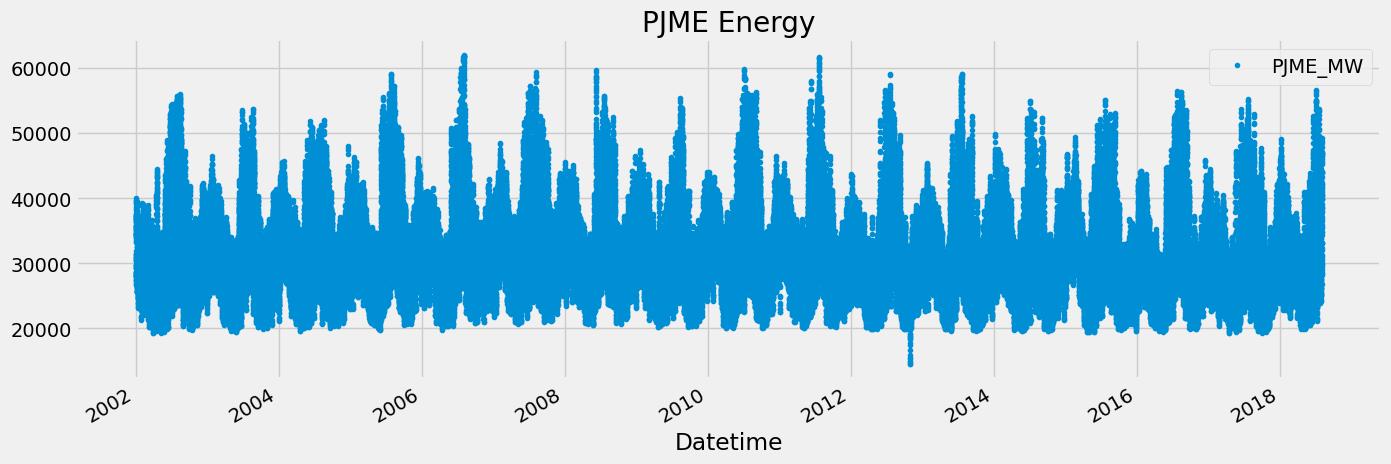

In [45]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJME Energy')# Show the plot, setting the figure size, size means width and height in inches

TRAIN / TEST Split

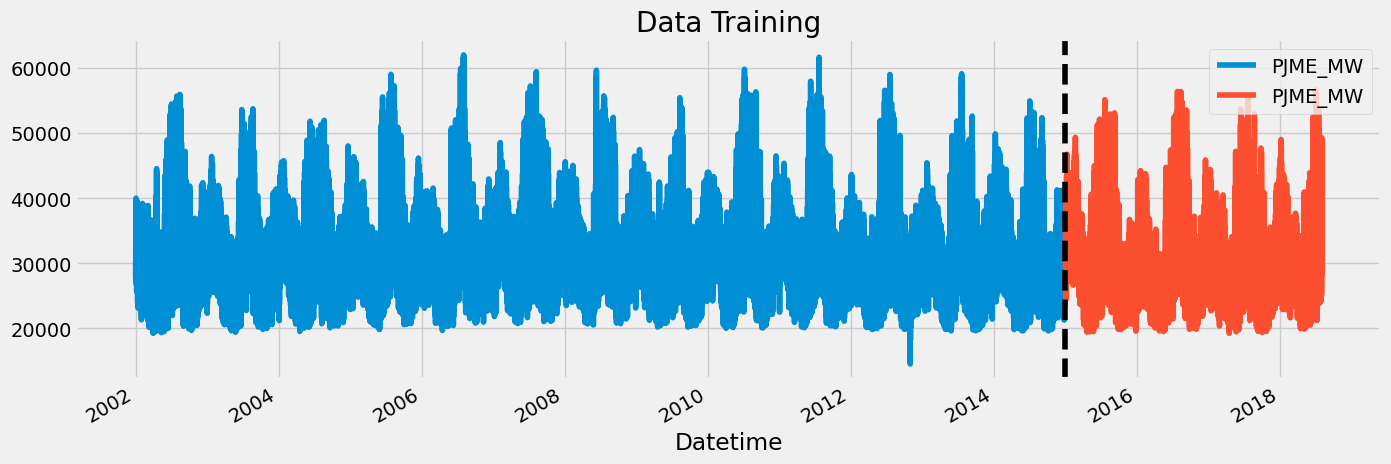

In [46]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Training', color=color_pal[0])
test.plot(ax=ax, label='Test Set', color=color_pal[1])
ax.axvline('01-01-2015', color='black', ls='--')

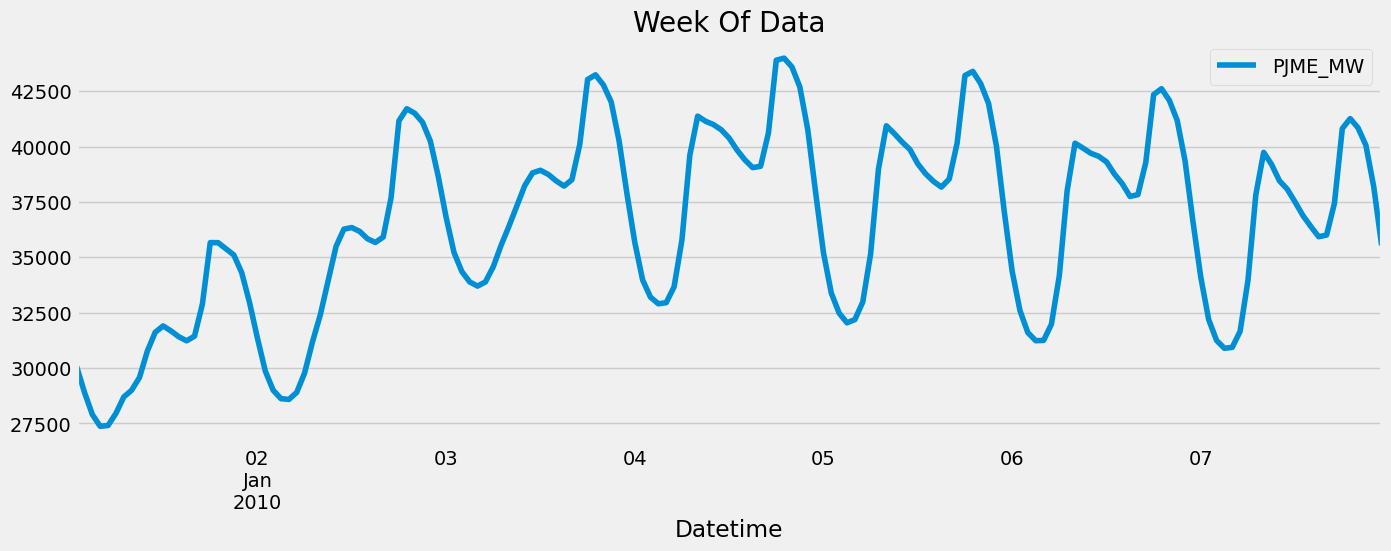

In [ ]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()
final_merged_data

Feature Creation

In [48]:
def create_features(df):
    '''Create time series features based on datetime index'''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df
df = create_features(df)

Visualize our Feature/Target Relationship


C:\Users\86176\AppData\Local\Temp\ipykernel_26300\2507283616.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df,x = 'hour',y = 'PJME_MW',palette = 'Blues')


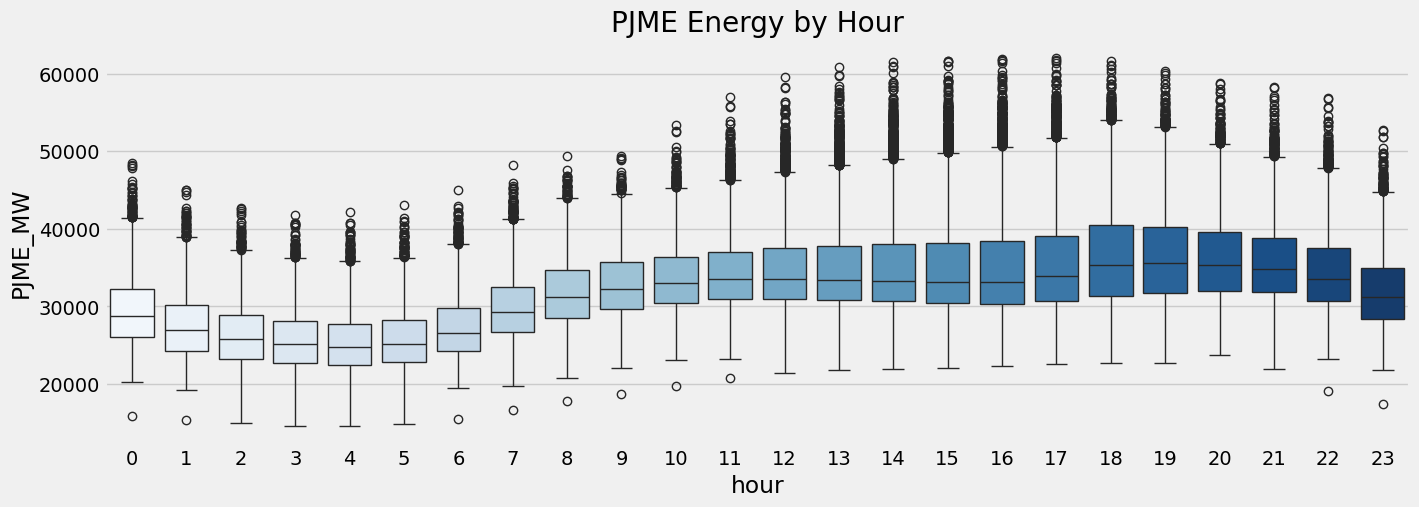

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data = df,x = 'hour',y = 'PJME_MW',palette = 'Blues')
ax.set_title('PJME Energy by Hour')
plt.show()

Create a Model

In [50]:
train = create_features(train)
test = create_features(test)

In [51]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [ ]:
X_train = train[FEATURES]#相当于train['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']去索取每一列
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [53]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=100,
                       learning_rate=0.01)
reg.fit(X_train, Y_train,eval_set=[(X_train, Y_train), (X_test, Y_test)],  verbose=100   )

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[466]	validation_0-rmse:2736.71611	validation_1-rmse:3768.31396


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Feature Importance

In [54]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance']).sort_values(by='importance', ascending=False)

<Axes: title={'center': 'Feature Importance'}>

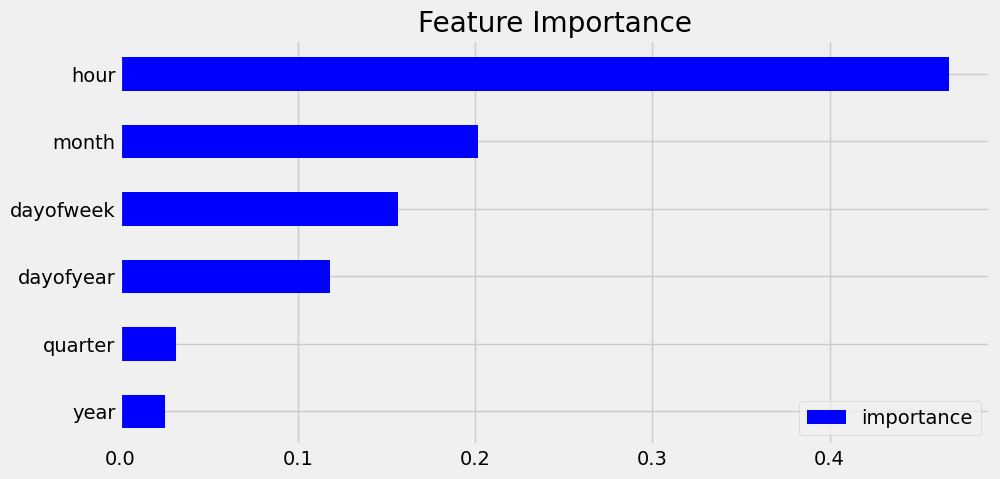

In [55]:
fi.sort_values(by='importance').plot(kind='barh', figsize=(10, 5), color='blue', title='Feature Importance')

Forcast on Test

In [56]:
test['prediction'] = reg.predict(X_test)

Text(0.5, 1.0, 'PJME Energy vs Prediction')

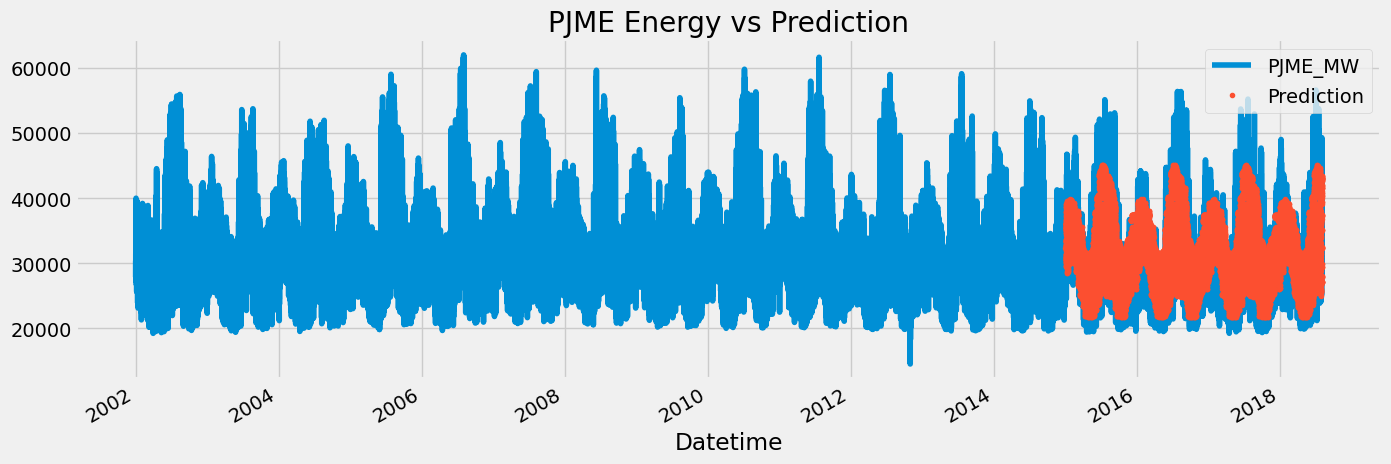

In [60]:
df = df.merge(test[['prediction']], how = 'left',left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot(ax=ax,style = '.')
plt.legend(['PJME_MW','Prediction'])
ax.set_title('PJME Energy vs Prediction')

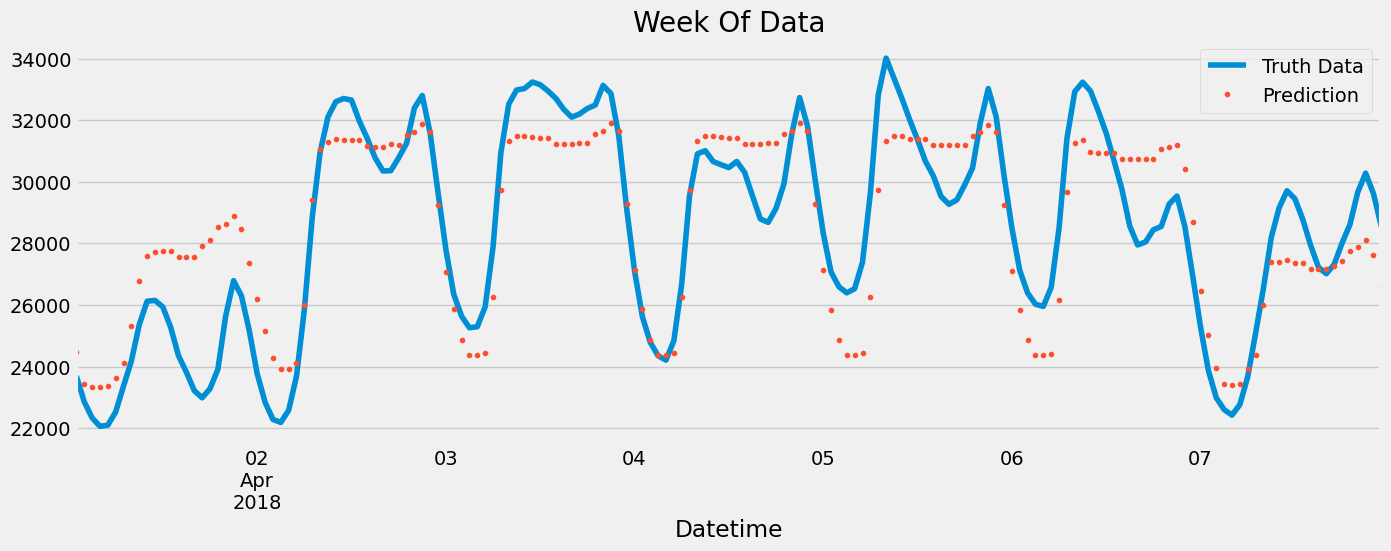

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(tyle='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score: {score:0.2f}')

RMSE Score: 3741.03


Calculate Error

In [79]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
2018-01-06    10407.698161
2015-02-20    10143.611491
2017-05-19     9495.122640
2016-07-04     9440.610596
2016-07-23     9362.332682
Name: error, dtype: float64

In [80]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
2015-10-28    459.086426
2016-06-03    467.453532
2018-02-06    477.327718
2016-08-08    496.441406
2016-12-12    553.641357
Name: error, dtype: float64

Next Steps¶
More robust cross validation
Add more features (weather forecast, holidays)